#### ALL FLOW

In [ ]:
import os
import shutil
import subprocess
def copy_all_from_runs_to_src():
    # get current directory
    cwd = os.getcwd()
    parent = os.path.dirname(cwd)
    parent = os.path.dirname(parent)
    src_folder = parent + '\\Generation\\runs\\' 
    dst_folder = './src/'
    for file_name in os.listdir(src_folder):
        shutil.copy(src_folder + file_name, dst_folder)
    print(f'Copied all files from {src_folder} to {dst_folder}')

def convert_to_pre_eval(exp_name):
    sf = f'src/{exp_name}.jsonl'
    #check if the file exists
    if not os.path.isfile(sf):
        print(f'File {sf} does not exist')
        return False
    td = f'tgt/{exp_name.replace("-", "")}'
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print(f'Converted {sf} to {td}')
    return True

def run_evaluation(exp_name, run_cmd=False, shell_script_path=None):
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    if run_cmd:
        subprocess.run(eval_cmd, shell=True)
    elif shell_script_path is not None:
        with open(shell_script_path, 'w') as f:
            f.write(eval_cmd)
        print(f'The evaluation command is saved to {shell_script_path}')
    else:
        print(f'The evaluation command is: \n{eval_cmd}\n Copy it and run it in the terminal')

def run_pass_k(exp_name):
    target_dir = f'tgt/{exp_name.replace("-", "")}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print(f'Pass@k results saved to {output_file}')


In [ ]:
copy_all_from_runs_to_src()

exp_names = []
my_folder = './src/'
for file_name in os.listdir(my_folder):
    exp_name = file_name.split('.jsonl')[0]
    exp_names.append(exp_name)
    print(exp_name)


exp_names = [

    'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_java_pass_at_10_gen_config',
    'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_py_pass_at_10_gen_config',
    'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rb_pass_at_10_gen_config',
    'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rs_pass_at_10_gen_config',
    'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_swift_pass_at_10_gen_config',


]

In [ ]:
def run_all(exp_name):
    print(f'{"="*20} Now running experiment: {exp_name} {"="*20}')
    success = convert_to_pre_eval(exp_name)
    if not success:
        print(f'{"="*20} Experiment: {exp_name} failed to convert to pre-eval format. Skipping {"="*20}')
        return
    # run_evaluation(exp_name, run_cmd=False)
    run_pass_k(exp_name)
    
for exp_name in exp_names:
    run_all(exp_name)



#### Visualize the results

Model name not found in dict: codegen_350M_mono_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_350M_mono_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_350M_mono_humaneval_rb_pass_at_10_gen_config
Model name not found in dict: codegen_350M_mono_humaneval_rs_pass_at_10_gen_config
Model name not found in dict: codegen_350M_mono_humaneval_swift_pass_at_10_gen_config
Model name not found in dict: codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_java_pass_at_100_gen_config
Model name not found in dict: codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_java_pass_at_10_gen_config
Model name not found in dict: codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_py_pass_at_10_gen_config
Model name not found in dict: codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rb_pass_at_10_gen_config
Model name not found in dict: codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rs_pass_at_10_gen_config
Model name not found

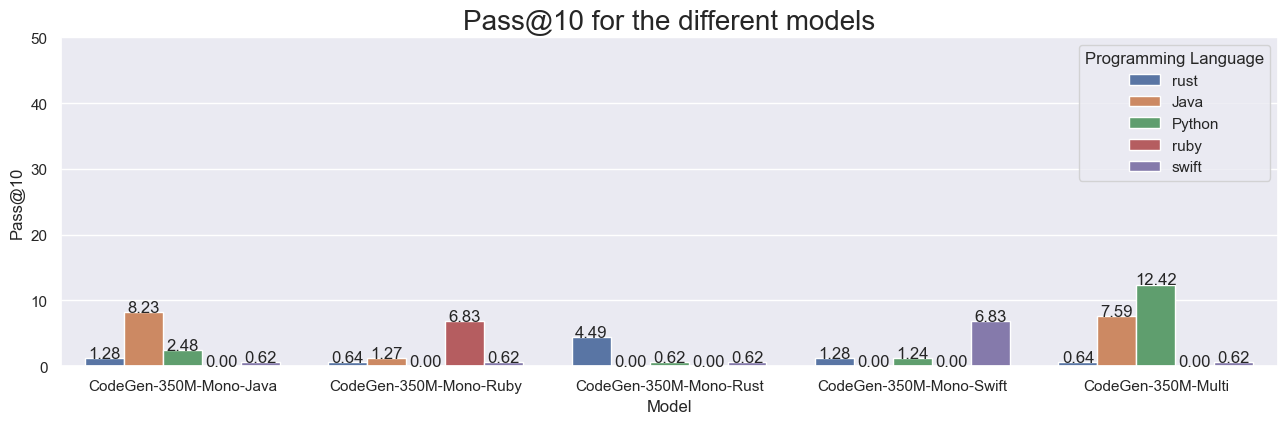

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
model_names_dict = {
    
    # 'codegen_350M_mono_humaneval_py_pass_at_10_gen_config': 'Baseline-mono',
    # 'codegen_350M_mono_humaneval_rb_pass_at_10_gen_config': 'Baseline-mono',
    # 'codegen_350M_mono_humaneval_rs_pass_at_10_gen_config': 'Baseline-mono',
    # 'codegen_350M_mono_humaneval_java_pass_at_10_gen_config': 'Baseline-mono',
    # 'codegen_350M_mono_humaneval_swift_pass_at_10_gen_config': 'Baseline-mono',
    
    # 'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'Full-Java',
    # 'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'Full-Java',
    # 'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'Full-Java',
    # 'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'Full-Java',
    # 'codegen_java_Full_v6.5_run_2_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'Full-Java',
    
    

    'codegen_350M_multi_humaneval_py_pass_at_10_gen_config': 'CodeGen-350M-Multi',
    'codegen_350M_multi_humaneval_rb_pass_at_10_gen_config': 'CodeGen-350M-Multi',
    'codegen_350M_multi_humaneval_rs_pass_at_10_gen_config': 'CodeGen-350M-Multi',
    'codegen_350M_multi_humaneval_java_pass_at_10_gen_config': 'CodeGen-350M-Multi',
    'codegen_350M_multi_humaneval_swift_pass_at_10_gen_config': 'CodeGen-350M-Multi',

    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'CodeGen-350M-Mono-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'CodeGen-350M-Mono-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'CodeGen-350M-Mono-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'CodeGen-350M-Mono-Java',
    'codegen_java_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'CodeGen-350M-Mono-Java',
    
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'CodeGen-350M-Mono-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'CodeGen-350M-Mono-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'CodeGen-350M-Mono-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'CodeGen-350M-Mono-Ruby',
    'codegen_ruby_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'CodeGen-350M-Mono-Ruby',

    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'CodeGen-350M-Mono-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'CodeGen-350M-Mono-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'CodeGen-350M-Mono-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'CodeGen-350M-Mono-Rust',
    'codegen_rust_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'CodeGen-350M-Mono-Rust',

    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_py_pass_at_10_gen_config': 'CodeGen-350M-Mono-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_rb_pass_at_10_gen_config': 'CodeGen-350M-Mono-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_rs_pass_at_10_gen_config': 'CodeGen-350M-Mono-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_java_pass_at_10_gen_config': 'CodeGen-350M-Mono-Swift',
    'codegen_swift_LoRa_v7_run_1_checkpoint_10000_humaneval_swift_pass_at_10_gen_config': 'CodeGen-350M-Mono-Swift',
}


#Merge all the results into a single dataframe
dict_df = { 'model': [], 'dataset': [], 'pass@10': [], 'pass@100': [], 'num_problems': [], 'min_completions': [], 'max_completions': [], 'programming_language': []}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    else:
        print('Model name not found in dict: ' + model_name)
        continue
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    elif 'humaneval_rs' in dataset_name:
        programming_language = 'rust'
    elif 'humaneval_rb' in dataset_name:
        programming_language = 'ruby'
    elif 'humaneval_swift' in dataset_name:
        programming_language = 'swift'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)
df = df.drop(columns=['dataset'])
df = df.drop(columns=['min_completions', 'max_completions'])
df = df[df['model'] != 'LoRa-V3-2000']
df = df[df['model'] != 'LoRa-V5-1000']
df['pass@10'] = df['pass@10'] * 100
df['pass@100'] = df['pass@100'] * 100

df = df.rename(columns={'programming_language': 'Programming Language'})
df = df.rename(columns={'model': 'Model'})
df = df.rename(columns={'pass@10': 'Pass@10'})
df = df.rename(columns={'pass@100': 'Pass@100'})

df['Programming Language'] = df['Programming Language'].replace({'java': 'Java', 'python': 'Python'})

#Sort the dataframe by the model name
df = df.sort_values(by=['Model'])

#Set the pass type to plot
pass_type = 'Pass@10'


#Plot the results
#Set the style
sns.set_theme(style="whitegrid")
#Set the plot size
sns.set(rc={'figure.figsize':(15.7,4.27)})
ax = sns.barplot(x="Model", y=pass_type, hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title(f'{pass_type} for the different models', fontsize=20)

fig_name = f'final_pass_at_10.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()



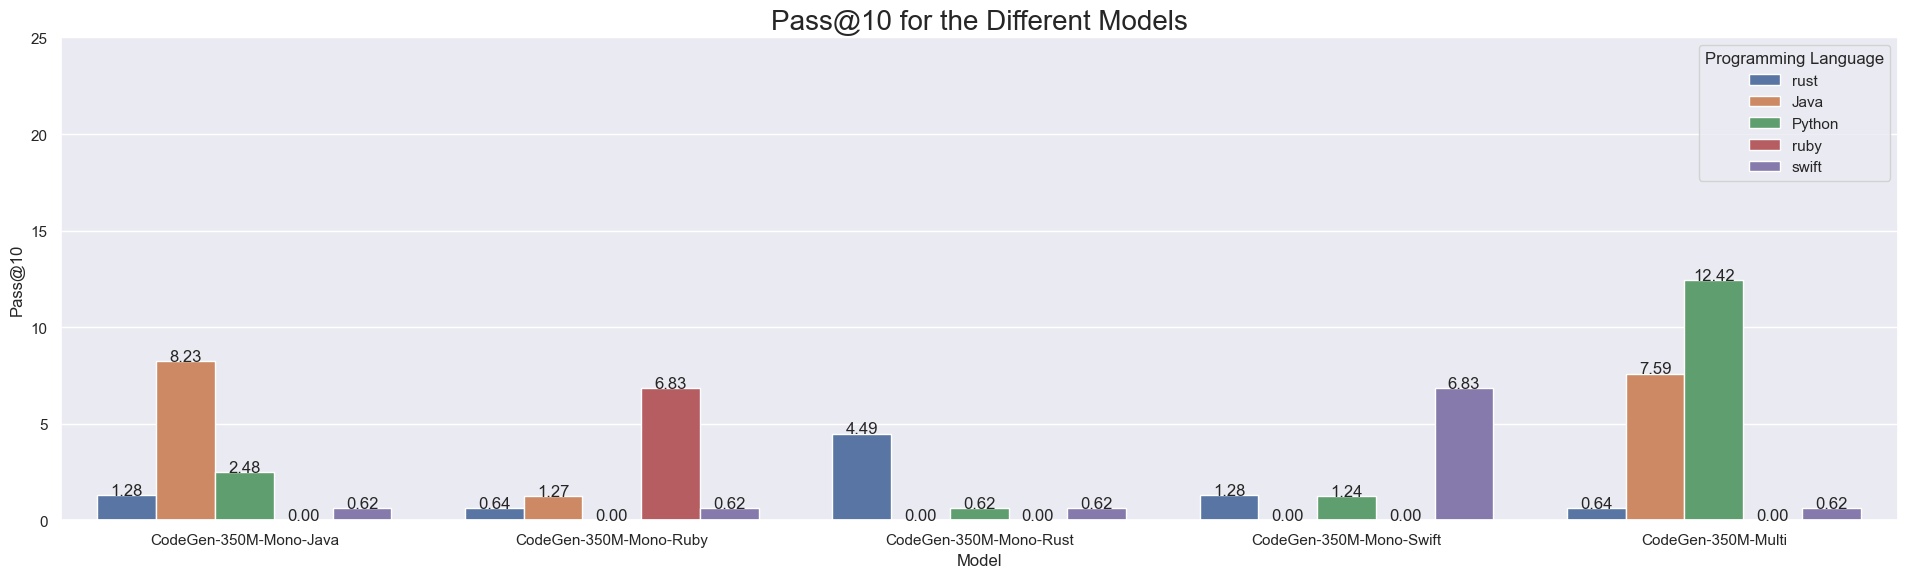

In [2]:
sns.set(rc={'figure.figsize':(23.7,6.27)})
ax = sns.barplot(x="Model", y=pass_type, hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 25)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title(f'{pass_type} for the Different Models', fontsize=20)

fig_name = f'final_pass_at_10.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()


In [ ]:
# df where programming language is Python
df_python = df[df['Programming Language'] == 'Python']

# df where programming language is Java
df_java = df[df['Programming Language'] == 'Java']

# df_python
# df_java
df